# Broad Overview of `hmf`

In this tutorial/demo, we provide a broad overview of the way `hmf` works, and its features. 
For those really just needing to make a quick plot of a mass function, the best place to start is in the [Quickstart](your_first_plot.html) tutorial. This tutorial will go into a little more depth (without exploring more advanced niche features).

## The Package Layout

`hmf` is quite modular, and contains a number of sub-packages concerning each of the physical components that go into defining the halo mass function:

In [1]:
from hmf import (
    cosmology,      # Defines cosmographic parameters and growth functions
    density_field,  # Defines power spectra and transfer functions, as well as window functions/filters on those
    halos,          # Defines halo-specific forms such as mass definitions
    mass_function   # Defines routines that combine the above to obtain halo mass functions
)

While each of these modules has tools that can be useful for more advanced usage, the primary point of contact with `hmf` is the `MassFunction` object, which essentially contains all the working of the full package. This lives in the `mass_function` submodule, but can be imported from the top level:

In [2]:
from hmf import MassFunction

## Frameworks -- Caching and Updating

Each main entrypoint class in `hmf` (this includes `Cosmology`, `Transfer` and `MassFunction`) is what we call a `Framework`. This name is not particularly descriptive, but it means that each of these objects offers a number of similar points of functionality. Here, we'll demonstrate a few of these bits of functionality on the `Transfer` class, but it should be remembered that they are the same for all of these.

In [3]:
from hmf import Transfer

In [4]:
tr = Transfer()

The first common point is that each of the frameworks has defaults for all of its parameters, and a reasonable object can be created by passing no parameters, as we just did.

We can, like any object in Python, get some help with what parameters are available by using `help`:

In [14]:
help(Transfer)

Help on class Transfer in module hmf.density_field.transfer:

class Transfer(hmf.cosmology.cosmo.Cosmology)
 |  Transfer(sigma_8=0.8159, n=0.9667, z=0.0, lnk_min=-18.420680743952367, lnk_max=9.903487552536127, dlnk=0.05, transfer_model=<class 'hmf.density_field.transfer_models.CAMB'>, transfer_params=None, takahashi=True, growth_model=None, growth_params=None, use_splined_growth=False, **kwargs)
 |  
 |  A transfer function framework.
 |  
 |  The purpose of this :class:`hmf._frameworks.Framework` is to calculate
 |  transfer functions, power spectra and several tightly associated
 |  quantities given a basic model for the transfer function.
 |  
 |  As in all frameworks, to update parameters optimally, use the
 |  :meth:`update` method. All output quantities are calculated only when needed
 |  (but stored after first calculation for quick access).
 |  
 |  In addition to the parameters directly passed to this class, others are available
 |  which are passed on to its superclass. To re

That's a lot of help! You can also consult the [API documentation](../api.html). However, since many of the parameters to `Transfer` merely get passed through to `Cosmology`, they get lost in this documentation. You can get a list of all possible parameters for a framework like this:

In [10]:
Transfer.get_all_parameter_defaults()

'FlatLambdaCDM' object has no attribute '_defaults'


{'cosmo_model': FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486),
 'cosmo_params': {},
 'n': 0.9667,
 'sigma_8': 0.8159,
 'growth_params': {'dlna': 0.01, 'amin': 1e-08},
 'lnk_min': -18.420680743952367,
 'lnk_max': 9.903487552536127,
 'dlnk': 0.05,
 'z': 0.0,
 'transfer_model': hmf.density_field.transfer_models.CAMB,
 'transfer_params': {'camb_params': None, 'dark_energy_params': {}},
 'takahashi': True,
 'growth_model': hmf.cosmology.growth_factor.GrowthFactor}

Again, you can consult the API docs for information on each one, bu you can also use this special function:

In [11]:
Transfer.parameter_info()

cosmo_model : instance of `astropy.cosmology.FLRW` subclass
    The basis for the cosmology -- see astropy documentation. Can be a custom
    subclass. Defaults to Planck15.

cosmo_params : dict
    Parameters for the cosmology that deviate from the base cosmology passed.
    This is useful for repeated updates of a single parameter (leaving others
    the same). Default is the empty dict. The parameters passed must match
    the allowed parameters of `cosmo_model`. For the basic class this is
    :Tcmb0: Temperature of the CMB at z=0
    :Neff: Number of massless neutrino species
    :m_nu: Mass of neutrino species (list)
    :H0: The hubble constant at z=0
    :Om0: The normalised matter density at z=0

n : float
    Spectral index of fluctuations
    Must be greater than -3 and less than 4.

sigma_8 : float
    RMS linear density fluctuations in spheres of radius 8 Mpc/h

growth_params : dict
    Relevant parameters of the :attr:`growth_model`.

lnk_min : float
    Minimum (natural)

Almost all of the things that a framework can calculate -- whether they be transfer functions, growth factors or mass functions -- will appear to be attributes of the object. That is, you don't "call" them like functions, but instead just access them like data. In fact, they are lazily calculated as needed, and then stored in memory once calculated. So, for example, let's calculate the matter power spectrum:

In [18]:
%time tr.power.max()

CPU times: user 21.8 s, sys: 72 ms, total: 21.9 s
Wall time: 2.84 s


25150.469248892314

This took almost 3 seconds on this system, as it called `CAMB` in the background to calculate the power spectrum.
However, it is now cached, and if we call it again:

In [19]:
%time tr.power.max()

CPU times: user 149 µs, sys: 0 ns, total: 149 µs
Wall time: 160 µs


25150.469248892314

It takes less than 1/1000 of a second, as its just accessing memory. More than that, each (non-trivial) quantity that the power spectrum depends on is also cached, so to access the transfer function:

In [21]:
%time tr.transfer_function.max()

CPU times: user 332 µs, sys: 0 ns, total: 332 µs
Wall time: 264 µs


1795.3826000699812

Also returns instantly. 

### Updating Parameters

Often you'll want to compute a certain quantity over a large number of values of a given parameter (or multiple parameters). Of course, you could just create a new framework each time (eg. a `Transfer` object), but that is often going to be much slower than necessary, because often the parameter does not affect many of the underlying quantities. For instance, updating the redshift doesn't change the underlying transfer function, and the power spectrum just changes by an overall factor. 

Internally, each framework keeps precise track of which parameters affect each quantity, which enables robust cache invalidation -- in other words, we can keep a computed quantity cached when a parameter is updated that doesn't affect it, and when other quantities that depend on that quantity are required, they can just access it again directly. Let's see this with an example -- 20 calculations of the power spectrum at different redshifts:

In [7]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [24]:
redshifts = np.random.uniform(0, 3, size=20)

CPU times: user 8min 7s, sys: 1.51 s, total: 8min 8s
Wall time: 1min 4s


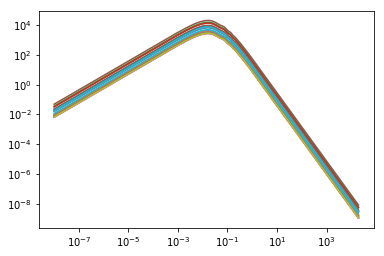

In [30]:
%%time 

for z in redshifts: 
    tr_ = Transfer(z=z)
    plt.plot(tr_.k, tr_.power)
    
plt.xscale('log')
plt.yscale('log');

If instead we use our original transfer object and merely update the redshift in-place:

CPU times: user 70.4 ms, sys: 2 µs, total: 70.4 ms
Wall time: 69 ms


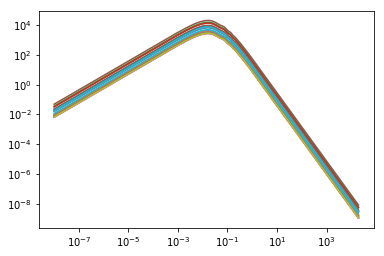

In [31]:
%%time 

for z in redshifts: 
    tr.z=z
    plt.plot(tr.k, tr.power)
    
plt.xscale('log')
plt.yscale('log');

See that the output plots are precisely the same -- the power spectrum is being updated for each redshift, but by using the caching mechanism we improve performance by three orders of magnitude.

You can also use the in-built `.update` method to update parameters:

In [32]:
tr.update(z=0)

## Components

Inside frameworks are a whole bunch of parameters. Some of these are simple numerical parameters, but many of them are themselves complex components tasked with computing specialized quantities. Furthermore, many of these components have various possible models that you might want to switch between. To make it easy to do so, we make each of these a formal `Component` object. Once instance of these is are the transfer function models themselves. We have been using CAMB to compute the transfer function, but a popular approximation is the Eisenstein-Hu model:

In [33]:
tr.transfer_model = 'EH'

For components, you can always pass a string referring to the name of the class, or the actual class itself:

In [36]:
tr.transfer_model = density_field.transfer_models.EH

The latter is useful because it gives you a lot of flexibility -- you could write your own class and pass it in! For more on that, see [Plugins and Extensions](plugins_and_extending.html).

All formal Components within `hmf` are passed to a framework via the `componentname_model` parameter. So Filters are passed as `filter_model`. The actual model instance (the thing that will do the calculations) is then available within the framework as as the component name:

In [37]:
tr.transfer

With this, we can compute a bunch of stuff, like the (log) transfer function:

In [38]:
tr.transfer.lnt(np.linspace(0,1,10))

array([-5.37333591, -5.55483193, -5.73752989, -5.92138382, -6.10634082,
       -6.29236711, -6.47942002, -6.66745701, -6.85644227, -7.04633679])

This is of course what is used to generate the transfer function accessible in the `Transfer` framework. But sometimes there are other goodies hidden away in the components that can be useful!

To update parameters of the components requires passing a dictionary of parameters to the parameter `componentname_params`. For example, the growth function is a component:

In [45]:
tr.growth_model

hmf.cosmology.growth_factor.GrowthFactor

We can update its params like so:

In [55]:
tr.growth_params = {'dlna': 1}  # By default it is 0.01

Let's compute the growth factor:

In [56]:
tr.growth.growth_factor(z=10)

0.10511507074207022

Now update back to the original

In [57]:
tr.growth_params = {"dlna": 0.01}

In [58]:
tr.growth.growth_factor(z=10)

0.11528461396801504

Another example of a Component is the cosmology, and you can see the [Dealing with Cosmology](deal_with_cosmology.html) tutorial for more details there -- but it follows the same pattern.

A full list of the available components in `hmf` is as follows:

* `Cosmology`
* `GrowthFactor`
* `TransferModel`
* `Filter`
* `MassDefinition`
* `FittingFunction`

And each of these has several models.

## Using `hmf` Efficiently

We have already discussed caching and how it speeds up many calculations very significantly. However, it is only useful if used correctly. Let's say you want to calculate the transfer function for multiple values of both $\Omega_m$ and the redshift $z$. Then to get the speedup, you must use the faster updater as the inner loop, otherwise the object still needs to compute the slower update many times. 

In this case, the redshift should be the inner loop, since $\Omega_m$ affects the basic transfer function, which is typically the slowest calculation of all. Much of the time, the relevant order of parameters should be clear, but you can determine them explicitly using a helper function:

In [59]:
from hmf import get_best_param_order

In [60]:
get_best_param_order(Transfer, q='power')

['takahashi',
 'z',
 'growth_model',
 'growth_params',
 'sigma_8',
 'n',
 'transfer_params',
 'transfer_model',
 'dlnk',
 'lnk_max',
 'lnk_min',
 'cosmo_params',
 'cosmo_model']

This call should be interpreted as determining the best order for calculating the `power` in the `Transfer` framework, and the output is in order of fastest to slowest. We see, for example, that `cosmo_params` (where $\Omega_m$ lives) is far down the list compared to redshift. 

You can go even further than that and use another helper function to "just get" the output quantities over the loop for you:

In [5]:
from hmf import get_hmf

{'Om0': 0.3} 0.0
{'Om0': 0.3} 1.0
{'Om0': 0.3} 2.0
{'Om0': 0.3} 3.0
{'Om0': 0.3} 4.0
{'Om0': 0.3} 5.0
{'Om0': 0.2} 0.0
{'Om0': 0.2} 1.0
{'Om0': 0.2} 2.0
{'Om0': 0.2} 3.0
{'Om0': 0.2} 4.0
{'Om0': 0.2} 5.0
{'Om0': 0.4} 0.0
{'Om0': 0.4} 1.0
{'Om0': 0.4} 2.0
{'Om0': 0.4} 3.0
{'Om0': 0.4} 4.0
{'Om0': 0.4} 5.0


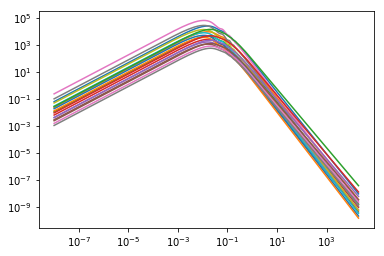

In [8]:
for power, tr, label in get_hmf(req_qauntities=['power'], 
                                framework=Transfer, 
                                fast_kwargs={"transfer_model": "EH"},
                               z=[0,1,2,3,4,5],
                               cosmo_params = [{'Om0': 0.3}, {'Om0': 0.2}, {'Om0': 0.4}]):
    print(tr.cosmo_params, tr.z)
    plt.plot(tr.k, tr.power)
    
plt.xscale("log")
plt.yscale('log')

Technically, the `get_hmf` function is an iterator, yielding the quantities you ask for (and the full Framework object updated with parameters) on each iteration, but doing it in the optimal order.